In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.interpolate import NearestNDInterpolator
%matplotlib inline

- Use algún método de interpolación en una malla regular,Voronoi por ejemplo
- Calcule la Transformada de Fourier de la señal regularmente remuestreada
- descarte las altas frecuencias
- Calcule la Transformada de Fourier inversa para producir el estimado f1
- Calcule el error f (n) − f1 (n), para1, . . . , N
- Interpole el error usando el método escogido y use este error estimado en cada punto para estimar f2 (n)...
- Itere recalculando la Transformada de Fourier

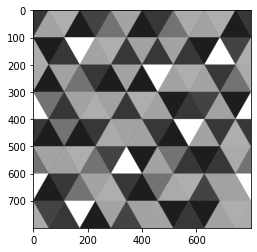

In [66]:
image = cv2.imread('patterns.png',flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')

In [67]:
H,W = image.shape
print(H,W)

800 800


In [68]:
image[H-1][W-1]

181

In [48]:

# return an array of random points(x,y) where x<=max_width and b<=max_height
def get_random_points(max_height,max_width,quantity):
    points = []
    while len(points)<quantity and len(points)<max_height*max_width:
        x_coord = random.randint(0,max_width-1)
        y_coord = random.randint(0,max_height-1)
        point = (x_coord,y_coord)
        if(point not in points):
            points.append((x_coord,y_coord))
    return points

# returns the irregular sampled image and the points used to evalute the value of the image    
def get_irregular_sampling(image,number_of_points):
    height , width = image.shape
    irregular_sampled_image = np.zeros(shape=(height,width))
    image_values=[]
    random_points = get_random_points(height,width,number_of_points)
    
    for i in range(number_of_points):
        x,y = random_points[i]
        irregular_sampled_image[y][x]=image[y][x]
        image_values.append(image[y][x])
    return irregular_sampled_image,random_points,image_values

def get_points(max_height,max_width):
    points = []
    for i in range(max_height):
        for j in range(max_width):
            points.append((i,j))
    return points

def get_regular_sampling(image):
    height , width = image.shape
    image_values=[]
    r_points = get_points(height,width)
    for i in range(len(r_points)):
        x,y = r_points[i]
        image_values.append(image[y][x])
    return r_points,image_values



def create_interpolated_image(interpolated_func,height,width):
    int_image = np.empty(shape=(height,width))
    for i in range(width):
        for j in range(height):
            int_image[j][i]=interpolated_func((i,j))
    return int_image

def plot_fourier_transform(fft):
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    plt.imshow(magnitude_spectrum,cmap='gray')
    return magnitude_spectrum ,np.abs(fft)

def plot_inverse_fourier_tranform(ifft):
    i_magnitude_spectrum = 20*np.log(np.abs(ifft))
    plt.imshow(i_magnitude_spectrum,cmap='gray')
    
    return i_magnitude_spectrum , np.abs(ifft)
def circle_img(r,x,y):
    circle_img = np.zeros(shape=(H,W), dtype=np.uint8)
    circle_img = cv2.circle(circle_img, (x,y) , r, (255,255,255), -1)
    return circle_img

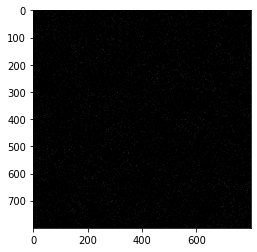

In [69]:
i_sampled_image,i_points,i_values = get_irregular_sampling(image,5000)
plt.imshow(i_sampled_image,cmap='gray')

In [50]:
interpolation = NearestNDInterpolator(i_points,i_values)

In [51]:
interpolation((25.3,30.2))

123

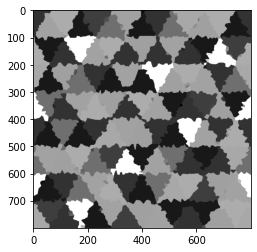

In [70]:
int_image = create_interpolated_image(interpolation,H,W)
plt.imshow(int_image,cmap='gray')

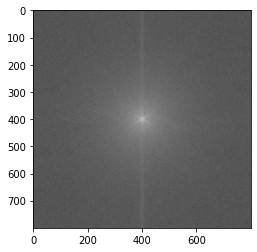

In [53]:
fft= np.fft.fft2(int_image)
magnitude_spectrum , raw_magnitude = plot_fourier_transform(fft)

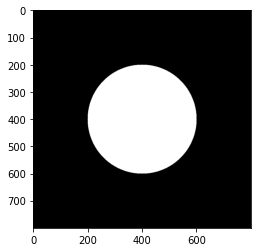

In [54]:
r=H//4
circle = circle_img(r,H//2,W//2)
plt.imshow(circle,cmap='gray')

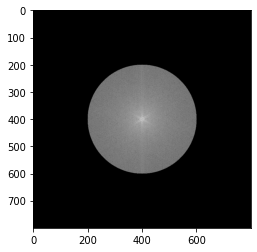

In [55]:
filtered_spectrum = circle*magnitude_spectrum
plt.imshow(filtered_spectrum,cmap='gray')

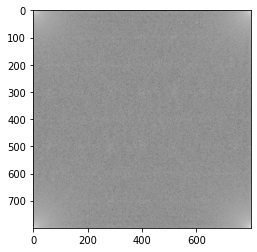

In [56]:
ifft =np.fft.ifft2(filtered_spectrum)
i_magnitude_spectrum,i_raw_magnitude = plot_inverse_fourier_tranform(ifft)


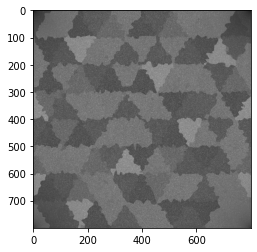

In [57]:
#error = i_sampled_image-i_magnitude_spectrum
error = int_image-i_magnitude_spectrum
plt.imshow(error,cmap='gray')

In [20]:
def reconstruc(f,A,fn):
    return fn + A *(f-fn)

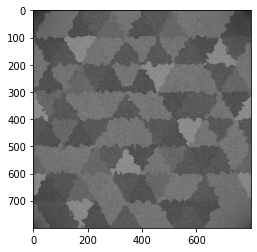

In [58]:
f2=reconstruc(int_image,np.identity(H),error)
plt.imshow(f2,cmap='gray')

# 2nd

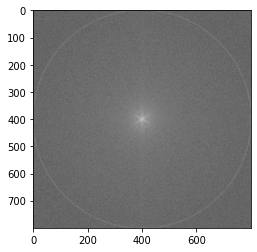

In [59]:
fft= np.fft.fft2(f2)
magnitude_spectrum , raw_magnitude = plot_fourier_transform(fft)

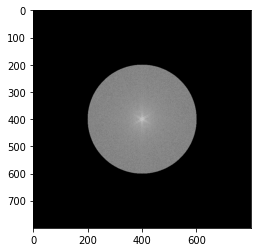

In [60]:
filtered_spectrum = circle*magnitude_spectrum
plt.imshow(filtered_spectrum,cmap='gray')

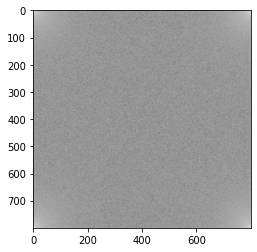

In [61]:
ifft =np.fft.ifft2(filtered_spectrum)
i_magnitude_spectrum,i_raw_magnitude = plot_inverse_fourier_tranform(ifft)

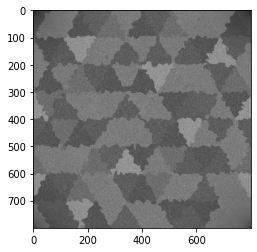

In [62]:
error = int_image-i_magnitude_spectrum
plt.imshow(error,cmap='gray')

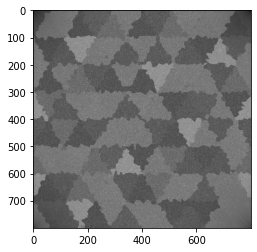

In [63]:
f3=reconstruc(int_image,np.identity(H),error)
plt.imshow(f3,cmap='gray')

In [74]:
def psnr(image,aproximation):
    H,W = image.shape
    for i in range (H):
        for j in range(W):
            mse = (image[i][j]-aproximation[i][j])**2
    return mse/(H*W)
psnr(image,f3)

0.0

In [64]:
def reconstruction_img(original_img,ITERATIONS,sampling_points):
    H,W= original_img.shape
    i_sampled_image,i_points,i_values = get_irregular_sampling(image,sampling_points)
    figure, axis = plt.subplots(4*ITERATIONS, ITERATIONS,figsize=(15,15))
    
    axis[0, 0].imshow(i_sampled_image,cmap='gray')
    axis[0, 0].set_title("Irregular Sampling")
    
    interpolation = NearestNDInterpolator(i_points,i_values)
    int_image = create_interpolated_image(interpolation,H,W)
    
    axis[0, 1].imshow(int_image,cmap='gray')
    axis[0, 1].set_title("Interpolated image")
    
    for i in range(ITERATIONS):
        fft= np.fft.fft2(int_image)
        fshift = np.fft.fftshift(fft)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        axis[i+1,0].imshow(magnitude_spectrum,cmap='gray')
        axis[i+1,0].set_title("FFT spectrum")
        
        r=H//4
        circle = circle_img(r,H//2,W//2)
        
        filtered_spectrum = circle*magnitude_spectrum
        axis[i+1,1].imshow(filtered_spectrum,cmap='gray')
        axis[i+1,1].set_title("filtered spectrum")
        
        ifft =np.fft.ifft2(filtered_spectrum)
        i_magnitude_spectrum = 20*np.log(np.abs(ifft))
        axis[i+2,0].imshow(i_magnitude_spectrum,cmap='gray')
        axis[i+2,0].set_title("ifft spectrum")
    plt.show()
    

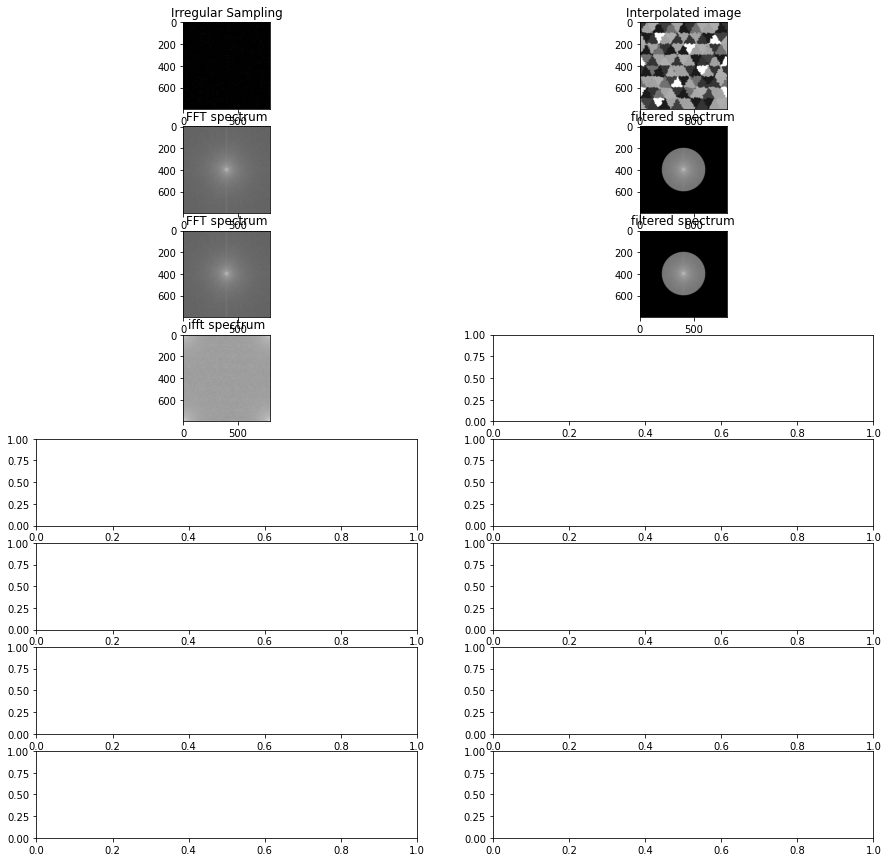

In [65]:
reconstruction_img(image,2,5000)

*** Sanity Check

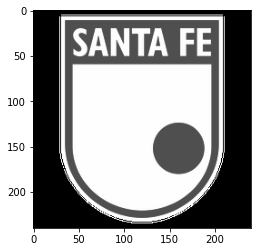

In [12]:
image = cv2.imread('SFE.png',flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')

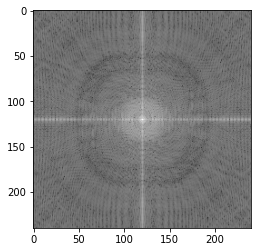

In [13]:
fft= np.fft.fft2(image)
magnitude_spectrum , raw_magnitude = plot_fourier_transform(fft)

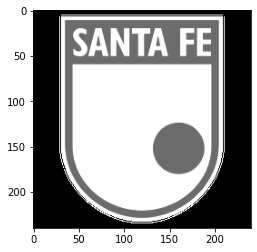

In [16]:
ifft = np.fft.ifft2(fft)
i_magnitude_spectrum,i_raw_magnitude = plot_inverse_fourier_tranform(ifft)